In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
# Define the WNVParameters class
class WNVParameters:
    def __init__(self):
        self.transovarial_rate = 0.05  # Probability of vertical transmission in mosquitoes
        self.mosquito_life_span = 15  # Average lifespan of mosquitoes in days
        self.bird_life_span = 365  # Average lifespan of birds in days
        self.initial_mosquito_count = 40716
        self.initial_bird_count = 15296
        self.initial_infectious_fraction = 0.1
        self.recovery_rate = 0.05  # Probability of recovery for infected birds
        self.grid_width = 921
        self.grid_height = 393
        self.startDOY = 1
        self.simulation_steps = 360

    def mosquito_abundance_probability(self, T):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        sigma = 5
        if T >= optimal_temp :
            sigma = 9  # Controls the width of the peak around the optimal temperature
        temp_factor = np.exp(-0.5 * ((T - optimal_temp) / sigma) ** 2)  # Gaussian function for temperature
        temp_factor = np.clip(temp_factor, 0, 1)  # Ensuring values are between 0 and 1
        return temp_factor * (1 - (T - 25) / 26)  # Gradually decrease after 26

    ##################################################

    def mosquito_birth_rate(self, T, H):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        lower_temp_limit = 15  # Updated lower temperature threshold for breeding
        upper_temp_limit = 35  # Updated upper temperature threshold for breeding
        optimal_humidity = 70  # Optimal humidity for mosquito breeding
        lower_humidity_limit = 0  # Updated lower humidity threshold for breeding
        upper_humidity_limit = 90  # Updated upper humidity threshold for breeding

        # Temperature factor based on Gaussian-like distribution around the optimal temperature
        temp_factor = np.where(T < lower_temp_limit,
                            0.2,  # Lower birth rate with very low temperature
                            np.where(T <= upper_temp_limit,
                                        np.exp(-0.02 * (T - optimal_temp) ** 2),  # Near-optimal birth rate at optimal temperature
                                        0.2))  # Lower birth rate with very high temperature
        
        # Humidity factor based on Gaussian-like distribution around the optimal humidity
        humidity_factor = np.where(H < lower_humidity_limit,
                                0.3,  # Lower birth rate with very low humidity
                                np.where(H <= upper_humidity_limit,
                                            np.exp(-0.001 * (H - optimal_humidity) ** 2),  # Near-optimal birth rate at optimal humidity
                                            0.2))  # Lower birth rate with very high humidity

        # Combine factors with a baseline birth rate
        return 0.1 * temp_factor * humidity_factor


    def mosquito_death_rate(self, T, H):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        lower_temp_limit = 10  # Lower temperature limit for mosquito survival
        upper_temp_limit = 40  # Updated upper temperature limit for mosquito survival
        optimal_humidity = 70  # Optimal humidity for mosquito survival
        lower_humidity_limit = 50  # Updated lower humidity limit for mosquito survival
        upper_humidity_limit = 90  # Updated upper humidity limit for mosquito survival

        # Temperature factor: more mortality further from the optimal temperature
        temp_factor = np.where(T < lower_temp_limit,
                            0.8,  # Higher mortality with very low temperature
                            np.where(T <= upper_temp_limit,
                                        1 - np.exp(-0.01 * (T - optimal_temp) ** 2),  # Lower mortality near optimal temperature
                                        0.8))  # Higher mortality with very high temperature
        
        # Humidity factor: more mortality further from the optimal humidity
        humidity_factor = np.where(H < lower_humidity_limit,
                                0.8,  # Higher mortality with very low humidity
                                np.where(H <= upper_humidity_limit,
                                            1 - np.exp(-0.005 * (H - optimal_humidity) ** 2),  # Lower mortality near optimal humidity
                                            0.8))  # Higher mortality with very high humidity

        # Combine factors with a baseline death rate
        return 0.01 + 0.06 * temp_factor * humidity_factor


    ##################################################

    def bird_birth_rate(self, T, P):
        optimal_temp = 25  # Optimal temperature for American crows
        variance = 0.008  # Decrease this value to make the curve wider
        temp_factor = np.exp(-variance * (T - optimal_temp) ** 2)  # Gaussian function for temperature
        return 0.05 * temp_factor * 0.5  # Decrease multiplier to make the peak lower

    def bird_death_rate(self, T):
        optimal_temp = 35  # Optimal temperature for American crows
        spread = 10  # Spread factor to control the steepness of the curve
        temp_factor = np.exp(-((T - optimal_temp) ** 2) / (2 * spread ** 2))
        # Adjusted to make the minimum death rate higher
        return 0.05 * (1 - temp_factor)
    
    def egg_to_larvae_rate(self, T, P):
        optimal_temp = 25  # Optimal temperature for mosquito eggs
        optimal_precip = 70  # Optimal precipitation for mosquito breeding
        temp_factor = np.exp(-0.02 * (T - optimal_temp) ** 2)  # Wider Gaussian function for temperature
        precip_factor = np.exp(-0.01 * (P - optimal_precip) ** 2)  # Wider Gaussian function for precipitation
        return 0.1 + 0.2 * temp_factor * precip_factor

    ##################################################

    def infection_probability(self, T):
        optimal_temp = 25  # Optimal temperature for WNV transmission
        spread = 10  # Spread factor to control the steepness of the curve
        temp_factor = np.exp(-((T - optimal_temp) ** 2) / (2 * spread ** 2))
        return 0.1 * temp_factor

In [26]:
# Instantiate the model
model = WNVParameters()

# Plot each function
def plot_surface(Z, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, H, Z, cmap='viridis')
    ax.set_xlabel('Temperature (T)')
    ax.set_ylabel('humidity (H)')
    ax.set_zlabel(title)
    plt.title(title)
    plt.show()

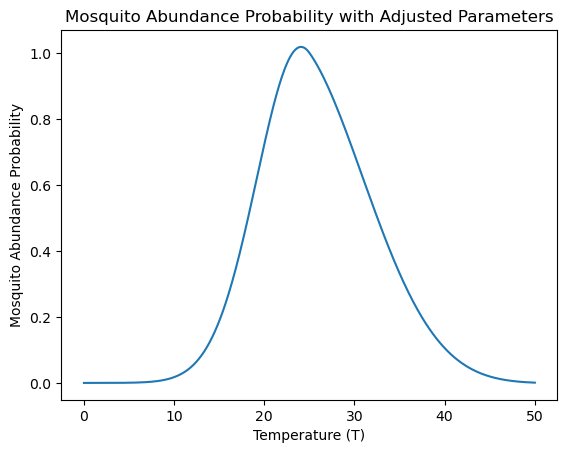

In [11]:
T_values = np.linspace(0, 50, 500)
probabilities = [model.mosquito_abundance_probability(T) for T in T_values]

plt.plot(T_values, probabilities)
plt.xlabel('Temperature (T)')
plt.ylabel('Mosquito Abundance Probability')
plt.title('Mosquito Abundance Probability with Adjusted Parameters')
plt.show()

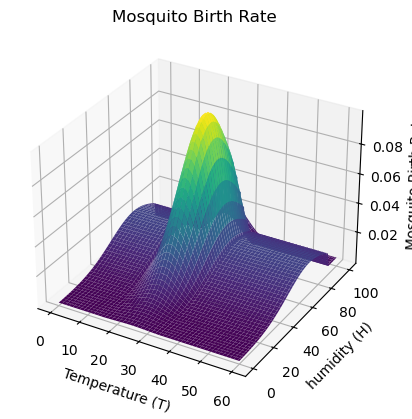

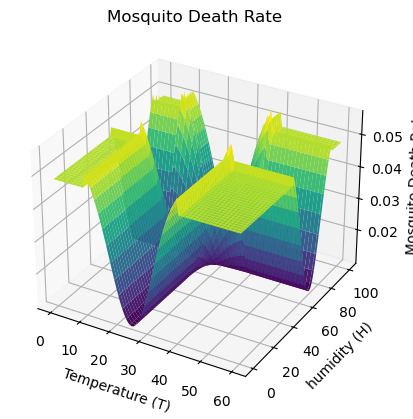

In [29]:
model = WNVParameters()

# Generate data
T_range = np.linspace(0, 60, 100)
P_range = np.linspace(0, 100, 100)
T, H = np.meshgrid(T_range, P_range)

# Plot mosquito birth rate
Z = model.mosquito_birth_rate(T, H)
plot_surface(Z, 'Mosquito Birth Rate')

Z = model.mosquito_death_rate(T, H)
plot_surface(Z, 'Mosquito Death Rate')

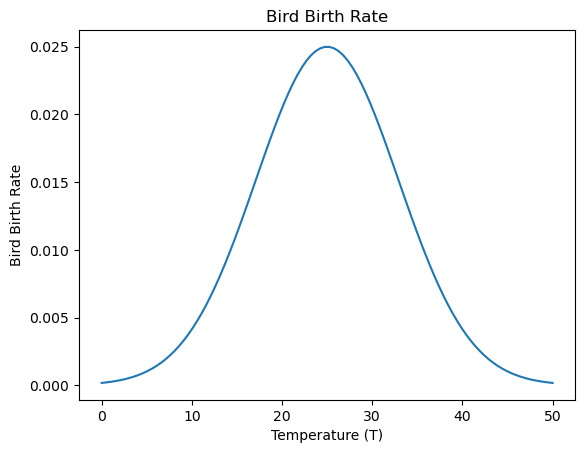

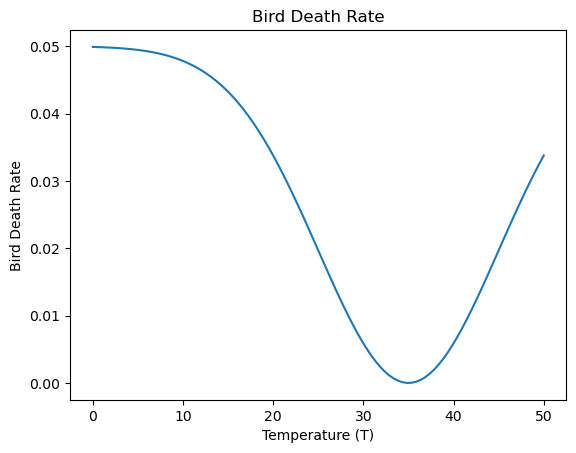

In [13]:

# Plot bird birth rate (only T, so no precipitation)
T_bird = np.linspace(0, 50, 100)
P_bird = np.linspace(0, 100, 100)
Z_bird = model.bird_birth_rate(T_bird, P_bird)
plt.figure()
plt.plot(T_bird, Z_bird)
plt.xlabel('Temperature (T)')
plt.ylabel('Bird Birth Rate')
plt.title('Bird Birth Rate')
plt.show()

# Plot bird death rate (only T, so no precipitation)
Z_bird_death = model.bird_death_rate(T_bird)
plt.figure()
plt.plot(T_bird, Z_bird_death)
plt.xlabel('Temperature (T)')
plt.ylabel('Bird Death Rate')
plt.title('Bird Death Rate')
plt.show()

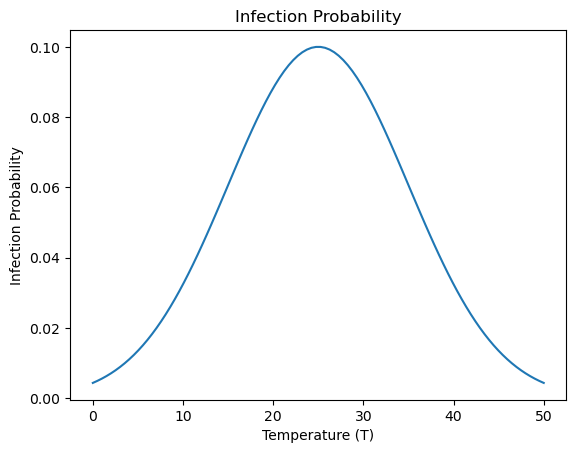

In [7]:
Z_infection = model.infection_probability(T_bird)
plt.figure()
plt.plot(T_bird, Z_infection)
plt.xlabel('Temperature (T)')
plt.ylabel('Infection Probability')
plt.title('Infection Probability')
plt.show()